In [2]:
#!pip install .

In [ ]:
## Option 1:
## If vpn enables downloading, directly load from_pretrained script from the huggingface
## Option 2:
## If vpn disables downloading but we can get the safetensors (available at huggingface moment's page 5 days ago),
## download the safetensors from the huggingface and save to bcs, then load with local_files_only=True. Change the path from pre-trained
## Option 3:
## Find the already downloaded pytorch_model.bin file, load it up starting from the 4th cell block (omit the third one).

In [19]:
from momentfm import MOMENTPipeline
import torch
from momentfm import MOMENT
import torch

####### Option 1 and Option 2##########################
#model loading module
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 192, #####TODO by Xueying: change the forecast horizon for each task (for example, ETTH1 has 96/192)
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)
model.init()
print(model)



MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

In [37]:
########## Option 3##############################
#replace the above block with the following codes to disable the downloading from hugging face

args = {"task_name": "reconstruction", 
"model_name": "MOMENT", 
"transformer_type": "encoder_only", 
"d_model": None, 
"seq_len": 512, 
"patch_len": 8, 
"patch_stride_len": 8, 
"device": "cuda", 
"transformer_backbone": "google/flan-t5-large", 
"model_kwargs": {
        'task_name': 'reconstruction',
        'forecast_horizon': 192, #####TODO by Xueying: change the forecast horizon for each task (for example, ETTH1 has 96/192)
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
"t5_config": {
    "architectures": [
      "T5ForConditionalGeneration"
    ],
    "d_ff": 2816,
    "d_kv": 64,
    "d_model": 1024,
    "decoder_start_token_id": 0,
    "dropout_rate": 0.1,
    "eos_token_id": 1,
    "feed_forward_proj": "gated-gelu",
    "initializer_factor": 1.0,
    "is_encoder_decoder": True,
    "layer_norm_epsilon": 1e-06,
    "model_type": "t5",
    "n_positions": 512,
    "num_decoder_layers": 24,
    "num_heads": 16,
    "num_layers": 24,
    "output_past": True,
    "pad_token_id": 0,
    "relative_attention_max_distance": 128,
    "relative_attention_num_buckets": 32,
    "tie_word_embeddings": False,
    "use_cache": True,
    "vocab_size": 32128
  }
}


In [38]:
load_dict = torch.load('pytorch_model.bin')
model = MOMENT(args,**args)
model.load_state_dict(load_dict)

model.task_name = 'forecasting'
model.head = model._get_head(model.task_name)

print("Unfrozen parameters:")
for name, param in model.named_parameters():    
    if param.requires_grad:
        print('    ', name)
        
print(model)

Unfrozen parameters:
     head.linear.weight
     head.linear.bias


### Finetuning Scripts for ETTH1

In [40]:
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.data.informer_dataset import InformerDataset
from momentfm.utils.forecasting_metrics import get_forecasting_metrics


In [42]:
# Load data
# train_dataset: a tuple of three elements
# first element is 7*512 (7 is the dimension of ETTh1, 512 is the lookback window/context length)
# second element is 7*192 (7 is the dimension, 192 is the forecast dimension)
# third element is 512 (no masking, so 512*1 of number 1)


## Note: put ETTh1 data in ../data/ETTh1 folder of this jupyter notebook should give load the data successfully 

train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=192)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=192)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)


In [56]:
#snapshot
print("context: ", train_dataset[0][0].shape)
print("pred: ", train_dataset[0][1].shape)
print("mask: ", train_dataset[0][2].shape)
print(train_dataset[0][2])

context:  (7, 512)
pred:  (7, 192)
mask:  (512,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1

In [53]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = 1

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(timeseries, input_mask)
        
        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1
    
    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(timeseries, input_mask)
            
            loss = criterion(output.forecast, forecast)                
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())
    
    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)
    
    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")


  0%|          | 0/993 [00:00<?, ?it/s]/home/xding2/.conda/envs/unify/lib/python3.11/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 993/993 [02:06<00:00,  7.83it/s]


Epoch 0: Train loss: 0.471


100%|██████████| 337/337 [00:35<00:00,  9.42it/s]


Epoch 1: Test MSE: 0.420 | Test MAE: 0.430


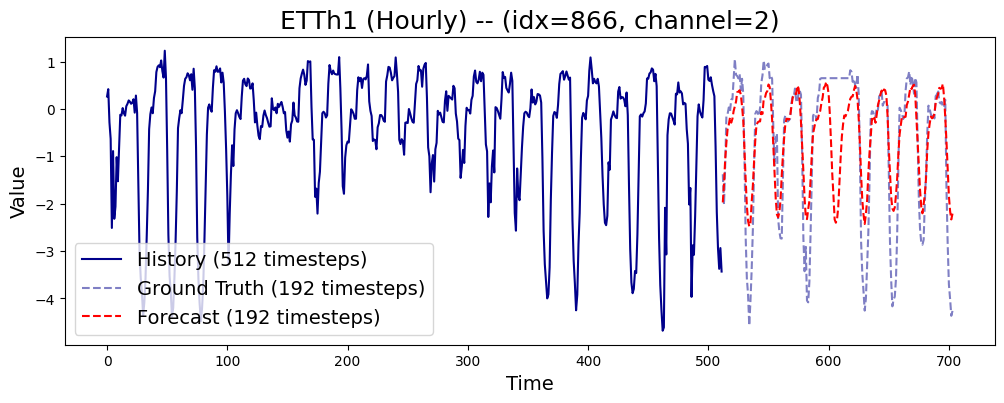

In [55]:
import matplotlib.pyplot as plt

# Assuming histories, trues, and preds are your lists containing the data
# Extracting the first data point

channel_idx = np.random.randint(0, 7) # There are 7 channels in this dataset
time_index = np.random.randint(0, trues.shape[0]) 

history = histories[time_index, channel_idx, :] 
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label='History (512 timesteps)', c='darkblue')

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(range(offset, offset + len(true)), true, label='Ground Truth (192 timesteps)', color='darkblue', linestyle='--', alpha=0.5)
plt.plot(range(offset, offset + len(pred)), pred, label='Forecast (192 timesteps)', color='red', linestyle='--')

plt.title(f"ETTh1 (Hourly) -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=14)
plt.show()